# Matrix Equivalents of Hypercomplex Numbers

Two numbers from a hypercomplex algebra $z, w \in \mathbb{H}^N$ can be multiplied such that the result $m = zw, m \in \mathbb{H}^N$ is an element of the same algebra. The space is closed under addition as well, and so hypercomplex algebras are also vector spaces.

The map between an elementwise product of two hypercomplex vector  $\hat{z}, \hat{w} \in \mathbb{H}^{M \times N}$ can be viewed as as a linear transformation on the elements of the right factor of the product $\hat{m} = \hat{z} \hat{w} = A \hat{w}$.

Here the matrix $A$ depends on the entries of the geometric vector $\hat{z}$. In this notebook, we explore a systematic way to generate these transformation matrices.

$\hat{z}, \hat{w} \in \mathbb{H}^{M \times N}$

$\hat{m} \in \mathbb{H}^{M \times N}, \hat{z} \hat{w} = \hat{m} $

frame as a linear transformation with matrix $A_{[\hat{z}]}$ conitioned on $\hat{z}$

$ A_{[\hat{z}]} \hat{w} = \hat{m} $ 

estimate $A_{[\hat{z}]}$ given $\hat{w}, \hat{m}$ with a static $\hat{z}$ by randomly sampling $\hat{w}$ and computing $\hat{m}$

$ A_{[\hat{z}]}[t] \in \mathbb{R}^{N \times N}, A_{[\hat{z}]}[t + 1] = (\hat{y}[t] \hat{x}[t]^{T} + \gamma A_{[\hat{z}]}[t])(\hat{x}[t] \hat{x}[t]^{T} + \gamma I)^{-1} $

reduce equation in terms of $A_{[\hat{z}]}[0]$

$ A_{[\hat{z}]}[t] = \gamma^{t} A_{[\hat{z}]}[0] (\hat{x}[t] \hat{x}[t]^{T} + \gamma I)^{-t} + \sum_{i = 1}^{t} \gamma^{i - 1} \hat{y}[i] \hat{x}[i]^{T} \prod_{j = i}^{N - i + 1} (\hat{x}[j] \hat{x}[j]^{T} + \gamma I)^{-1} $

assume $ |\gamma| < 1 $ and take limit $ t \rightarrow \infty $

$ A_{[\hat{z}]}[t \rightarrow \infty] = \sum_{i = 1}^{\infty} \gamma^{i - 1} \hat{y}[i] \hat{x}[i]^{T} \prod_{j = i}^{N - i + 1} (\hat{x}[j] \hat{x}[j]^{T} + \gamma I)^{-1} $

does not depend on the initial choice of $A_{[\hat{z}]}[0]$ and converges for large $t$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def hypercomplex_conjugate(a):
    c = np.ones(a.shape)
    c[..., 1:] *= -1
    return c * a
def hypercomplex_multiply(a, b):
    if a.shape[-1] == 1:
        return a * b
    else:
        def cayley_dickson(p, q, r, s):
            return np.concatenate([
                (hypercomplex_multiply(
                    p,
                    r) -
                hypercomplex_multiply(
                    hypercomplex_conjugate(s),
                    q)),
                (hypercomplex_multiply(
                    s,
                    p) +
                hypercomplex_multiply(
                    q,
                    hypercomplex_conjugate(r))),
            ], axis=(len(a.shape) - 1))
        return cayley_dickson(
            a[..., :(a.shape[-1] // 2)],
            a[..., (a.shape[-1] // 2):],
            b[..., :(a.shape[-1] // 2)],
            b[..., (a.shape[-1] // 2):])

In [4]:
def hypercomplex_conjugate_gradient(a, da):
    return hypercomplex_conjugate(da)   
def hypercomplex_multiply_gradient(a, b, da, db):
    return (hypercomplex_multiply(da, b),
        hypercomplex_multiply(a, db))
def hypercomplex_basis_gradient(a):
    basis = np.zeros((a.shape[-1], a.shape[-1]))
    np.fill_diagonal(basis, 1)
    basis = basis.reshape((1, a.shape[-1], a.shape[-1]))
    return basis

In [5]:
class HCX(object):
    def random(*kdims, hcx_size=1, mean=0, std=1):
        shape = [
            kdims[i] if i < len(kdims) 
            else 2**hcx_size
            for i in range(len(kdims) + 1)]
        return np.random.normal(mean, std, shape)
    def basis(x, dx=0, dir=1):
        if dir > 0:
            return x
        else:
            return hypercomplex_basis_gradient(x)
    def conj(x, dx=0, dir=1):
        if dir > 0:
            return hypercomplex_conjugate(x)
        else:
            return hypercomplex_conjugate_gradient(x, dx)
    def add(x, y, dx=0, dy=0, dir=1):
        if dir > 0:
            return x + y
        else:
            return dx, dy
    def sub(x, y, dx=0, dy=0, dir=1):
        if dir > 0:
            return x - y
        else:
            return dx, -dy
    def mul(x, y, dx=0, dy=0, dir=1):
        if dir > 0:
            return hypercomplex_multiply(x, y)
        else:
            return hypercomplex_multiply_gradient(x, y, dx, dy)
    def norm(x, dx=0, dir=1):
        if dir > 0:
            return np.sum(
                hypercomplex_multiply(HCX.conj(x), x),
                axis=(len(x.shape) - 1))**0.5
        else:
            c = 0.5 / np.sum(
                hypercomplex_multiply(HCX.conj(x), x),
                axis=(x.shape[-1] - 1))**0.5
            g = hypercomplex_multiply_gradient(
                HCX.conj(x), 
                x, 
                HCX.conj(x, dx, dir=-1), 
                dx)
            r = HCX.conj(g[0]) + g[1]
            return c * r
    def inv(x, dx=0, dir=1):
        if dir > 0:
            return HCX.conj(x) / np.reshape(HCX.norm(x)**2, (-1, 1))
        else:
            return (HCX.conj(x, dx, dir=-1) 
                / HCX.norm(x)**2 
                - 2 * HCX.conj(x) 
                / HCX.norm(x)**3
                * HCX.norm(x, dx, dir=-1))

Estimation Loss: 5.95961373606e-14
Estimation Loss: 3.34650795567e-28
Iterations until Convergence: 200
a: [[[-0.26309808]
  [ 0.9445419 ]
  [-0.08696842]
  [-0.11006793]]]
A: [[[-0.26309808 -0.9445419   0.08696842  0.11006793]
  [ 0.9445419  -0.26309808  0.11006793 -0.08696842]
  [-0.08696842 -0.11006793 -0.26309808 -0.9445419 ]
  [-0.11006793  0.08696842  0.9445419  -0.26309808]]]


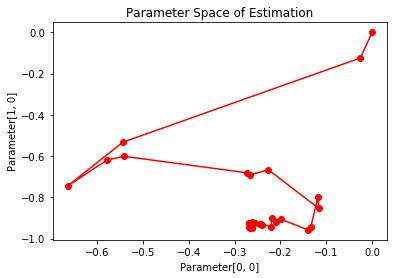

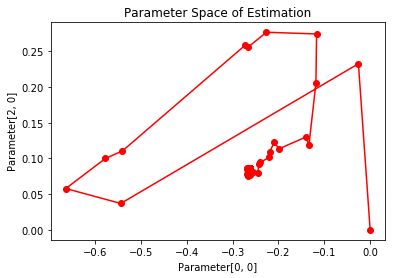

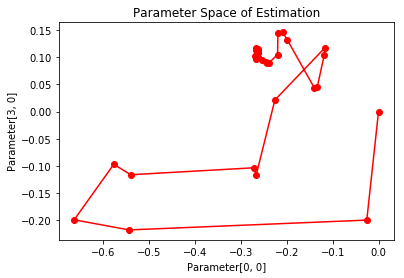

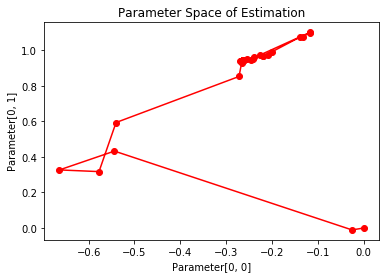

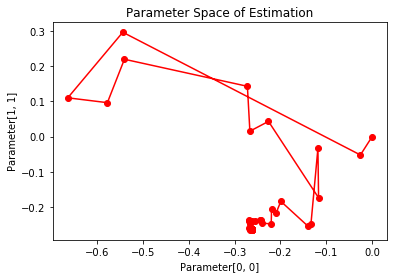

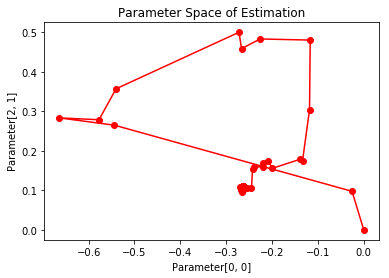

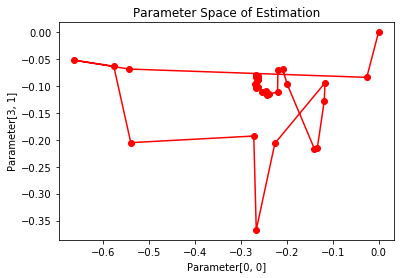

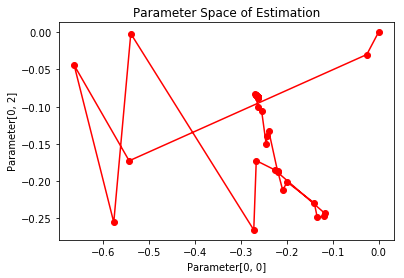

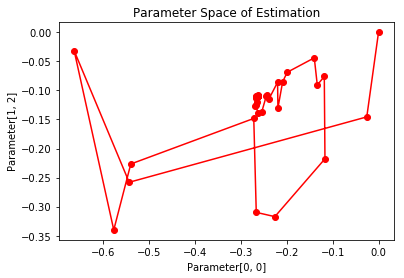

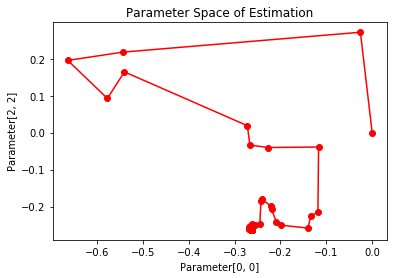

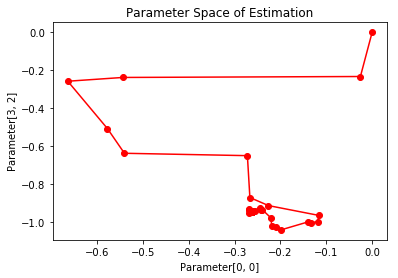

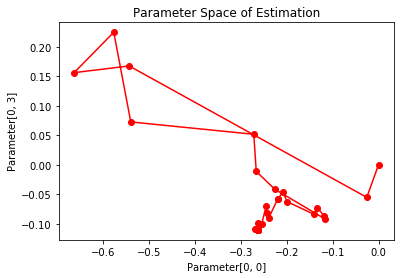

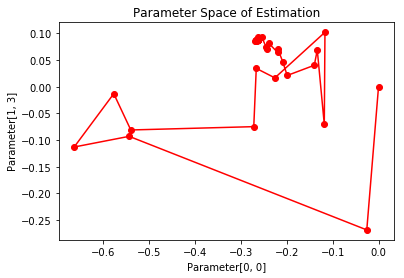

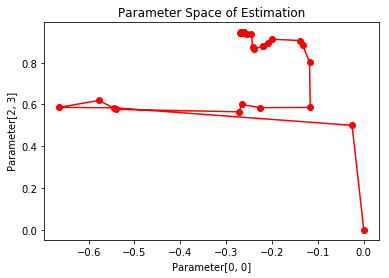

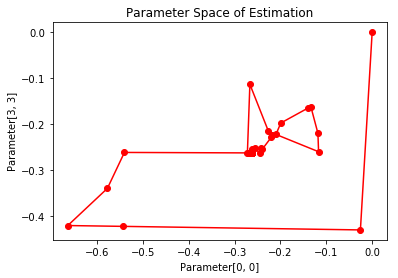

In [6]:
M = 2     # The hypercomplex size
N = 1     # The vector elements
T = 1e-20 # A convergenece threshold
L = 0.05  # A hyperparameter to tune
V = 100   # The number of validation steps
D = 100   # The number of iterations before validating


def validate(_a, _A):
    _loss = 0.0
    for i in range(V):
        _b = HCX.random(N, 1, hcx_size=M).transpose(0, 2, 1)
        _c = HCX.mul(
            _a.transpose(0, 2, 1), 
            _b.transpose(0, 2, 1)).transpose(0, 2, 1)
        _loss += np.sum(_c - np.matmul(_A, _b))**2
    return _loss / V


a = HCX.random(N, 1, hcx_size=M).transpose(0, 2, 1)
A = np.zeros((N, 2**M, 2**M))
I = np.reshape(np.eye(2**M), (1, 2**M, 2**M))
data_points = []


loss = 1.0
iterations = 0
while loss > T:
    iterations += 1
    b = HCX.random(N, 1, hcx_size=M).transpose(0, 2, 1)
    c = HCX.mul(
        a.transpose(0, 2, 1), 
        b.transpose(0, 2, 1)).transpose(0, 2, 1)
    data_points += [A]
    A = np.matmul(
        (c * b.transpose(0, 2, 1)) + L * A,
        np.linalg.inv(
            (b * b.transpose(0, 2, 1)) + L * I))
    if iterations % D == 0:
        loss = validate(a, A)
        print("Estimation Loss:", loss)
        
        
print("Iterations until Convergence:", iterations)
print("a:", a)
print("A:", A)


data_points = np.array(data_points).reshape(iterations, -1)
for i in range(1, N * 2**(2*M)):
    plt.title("Parameter Space of Estimation")
    plt.xlabel("Parameter" + str([0, 0]))
    plt.ylabel("Parameter" + str([i % 2**M, i // 2**M]))
    plt.plot(data_points[:, 0], data_points[:, i], "ro-")
    plt.show()

In [7]:
print(np.linalg.det(A)) # This matrix is full rank
eigen_values, eigen_vectors = np.linalg.eig(A)

[ 0.96247571]


In [8]:
print(eigen_values) # The eigenvalues have a particular structure

[[-0.26309808+0.95490202j -0.26309808-0.95490202j -0.26309808+0.95490202j
  -0.26309808-0.95490202j]]


In [9]:
print(eigen_vectors) # The eigenvectors have a particular structure

[[[-0.03789162+0.58363156j -0.03789162-0.58363156j -0.16978924-0.25567825j
   -0.16978924+0.25567825j]
  [ 0.62206215+0.j          0.62206215-0.j         -0.19349654+0.09563993j
   -0.19349654-0.09563993j]
  [ 0.33388776+0.07917172j  0.33388776-0.07917172j  0.65747462+0.j
    0.65747462-0.j        ]
  [ 0.01103976-0.39128768j  0.01103976+0.39128768j  0.03818154-0.65228953j
    0.03818154+0.65228953j]]]


## Developing a Neural Network with this Update Rule

In [160]:
class TrabuccoNet:
    
    def __init__(
            self, 
            *layers, 
            f=(lambda x: x), 
            f_inverse=(lambda x: x),
            use_b=False,
            alpha=0.01):
        self.f = f
        self.f_inverse = f_inverse
        self.weights = []
        self.biases = []
        self.use_b = use_b
        self.alpha = alpha
        for a, b in zip(
                layers[:-1],
                layers[1:]):
            self.weights += [
                np.random.normal(0, 1.0, (b, a))]
            self.biases += [
                np.zeros((b, 1))]
            
    def forward(
            self,
            x):
        self.activations = [x]
        for w, b in zip(
                self.weights,
                self.biases):
            self.activations += [
                self.f(np.matmul(
                    w,
                    self.activations[-1]) + b)]
        return self.activations[-1]
    
    def reverse(
            self,
            y):
        self.estimations = [y]
        for w, b in zip(
                reversed(self.weights),
                reversed(self.biases)):
            self.estimations = [
                np.matmul(
                    np.linalg.inv(np.matmul(w.T, w)),
                    np.matmul(
                        w.T,
                        (self.f_inverse(
                            self.estimations[0]) - b)))] + self.estimations
        return self.estimations[0]
    
    def update(
            self,
            layer=-1):
        i = layer % len(self.weights)
        self.weights[i] = np.matmul(
            (np.matmul(
                (self.f_inverse(self.estimations[i + 1]) - self.biases[i]),
                self.activations[i].T) + self.alpha * self.weights[i]),
            np.linalg.inv(
                np.matmul(
                    self.activations[i],
                    self.activations[i].T) 
                + self.alpha 
                * np.eye(self.activations[i].shape[0])))
        if self.use_b:
            self.biases[i] = self.f_inverse(
                self.estimations[i + 1]) - np.matmul(
                    self.weights[i],
                    self.activations[i])
            

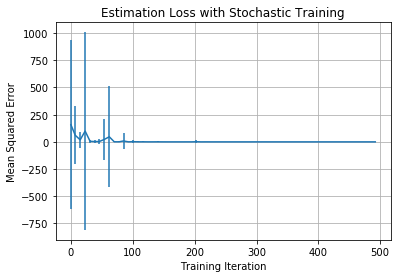

In [224]:
M = 2     # The hypercomplex size
T = 1e-6  # A convergenece threshold
V = 100   # The number of validation steps
D = 10    # The number of iterations before validating


def validate(_a, _net):
    _loss = 0.0
    for i in range(V):
        _b = HCX.random(1, hcx_size=M).T
        _c = HCX.mul(
            _a.T, 
            _b.T).T
        _loss += np.sum(_c - _net.forward(_b))**2
    return _loss / V


def train():
    net = TrabuccoNet(2**M, 2**M, 2**M, 2**M, alpha=0.5, use_b=True)
    a = HCX.random(1, hcx_size=M).T
    loss = []
    iterations = 0
    while len(loss) == 0 or loss[-1] > T:
        iterations += 1
        b = HCX.random(1, hcx_size=M).T
        c = HCX.mul(
            a.T, 
            b.T).T
        net.forward(b)
        net.reverse(c)
        net.update(layer=(iterations // D))
        if iterations % D == 0:
            loss += [validate(a, net)]
    return loss
        

losses = []
max_length = 0
for i in range(100):
    losses += [train()]
    max_length = max(max_length, len(losses[-1]))
for i in range(len(losses)):
    losses[i] += [0 for _ in range(max_length - len(losses[i]))]
losses = np.array(losses)


mean_loss, std_loss = np.mean(losses, axis=0), np.std(losses, axis=0)
plt.title("Estimation Loss with Stochastic Training")
plt.xlabel("Training Iteration")
plt.ylabel("Mean Squared Error")
plt.errorbar(
    (iterations * np.arange(len(mean_loss))) // len(mean_loss),
    mean_loss,
    yerr=std_loss)
plt.grid(True)
plt.show()